<h2>Topographic Classification: A Machine Learning Approach (Unsupervised Classification Analysis Notebook)</h2>

Clustering and Density Estimation using the Gaussian Mixture Model(1)
While I don't place much confidence in an unclassifed scheme being sufficiently robust to be able to parse the data distributions(2)(3) see in the plots generated during the initial EDA, it might be able to do enough to give us a hint as to how well a more robust supervised classifier (SVM in this case) might perform. To get a start toward finding out we'll turn to a Gaussian Mixture Model (GMM) to examine the homogeneity/heterogeneity of the data to assess how well a classifier might be able to topographically partition the data.


(1) We elected to forego the initial application of simpler classifiers such as k-means because the spatial distribution of our observation samples is a poor match against the assumption (by the k-means classifier) that the potential clusters be more or less separated in space and [hyper]spherically distributed. Our sample observations are nothing of the sort. 

(2) Information describing the data used in this analysis, and the preprocessing of that data, are described in detail in the notebook: Topographic Classification: A Machine Learning Approach (Exploratory Analysis)

(3) In the inital EDA we looked at the data unaltered from source. Here, due to requirements associated with the GMM algorithm(s) and the large scaling differences between the elevation, slope, and distance to shoreline attributes, we will be transforming the data to standard normal before proceeding with the density analyses.

**Load requisite libraries, modules, and magics:**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

sns.set()
%matplotlib inline

**Load the sample observations from GRASS**

In [49]:
### Load the Data from the GRASS (SQLITE3) database:

### to read the GRASS attribute table: u3krandompts into pandas (Note that there are actually
### 7,000 points in the file...)
datapath='/Users/paulp/GoogleDrive/projects/GRASSData/USAtl_CoastalPlain_Prototype_LCC/user/sqlite/'
fn='sqlite.db' 

conn=sqlite3.connect(datapath+fn)   # create a connection to the database file:

# with the first load and subsequent plot (scatters in next cell) we discovered that there was
# an errant value with a z value of approx. -10,000 meters!. Since the data comes to us from 
# the GTOPO30 dataset, we know that there should be no elevation < 0 meters, so we adjust the
# sSQL select statement to weed this outlier from our data before we proceed...
df = pd.read_sql_query('select * from u3krandompts where z > 0.0', conn)


# build the standardized X features and y target arrays:
scaler = StandardScaler()
X=scaler.fit_transform(np.array(df[['z','distance','slope']]) )
y=np.array(df['label'])    # recall that the label was assigned in the GIS
print(np.shape(y), np.shape(X))

(6839,) (6839, 3)


In [50]:
### GAUSSIAN MIXTURE MODELS: Experiments on the ENTIRE 7000 observation dataframe:

gmx=GaussianMixture(n_components=2, covariance_type='full')

gmx.fit(X)
y=gmx.predict(X)
df['cluster']=y   # GMM assign observation points to one of two clusters

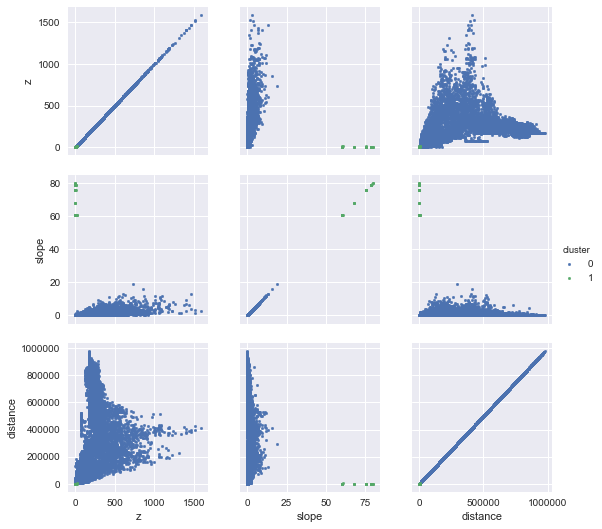

In [87]:
### PLOT SOME RESULTS:
#fg=sns.FacetGrid(data=df, size=7, hue='cluster', aspect=0.85)
#fg.map(plt.scatter, 'z', 'distance', s=5)
pg = sns.PairGrid(data=df, vars=['z','slope','distance'],  hue='cluster')
pg.map(plt.scatter, s=7)
pg.add_legend()

The results, for their relatively small size on the page, are difficult to assess (in terms of density distribution), however, the plots do suggest slope as playing a dominate role, with a collective of slopes in excess of 50 degrees being singled out versus the large majority which fall at angles under 25 degrees. Further, these unusually high slope angles seem to occur at lower elevations nearer to the modern shoreline--as noticed in the green 'speck' seen in the far lower left-hand corner of the elevation-distance plots.

If we elect to place some geomorphometric constraint on slope in crafting a topographic definition for a coastal plain in order to perhaps simplify interpretation we could appeal to some earlier work: _Paris, Walsh, and Corbett, 2016_ and hold maximum slopes for the coastal plain to that which applies to its submerged counterpart, the continental shelf, at 0.69 degrees. This would act to remove the influence of the few high slope angle samples. Such high angle can, and do, occur across the coastal plains, but in general, the character of the mean landscape here is flat to very gently sloping. 

In [53]:
### GAUSSIAN MIXTURE MODELS: Experiments on a subset of sample obervations where slope is 
### constrained to be <= 0.69 degrees:

# Extract a new dataframe from the query results where slopes are <= 0.69 degrees:
df2=df.query('slope <= 0.69')

# standardize the X features and y target arrays for the new dataframe: df2:
scaler = StandardScaler()
X=scaler.fit_transform(np.array(df2[['z','distance','slope']]) )
y=np.array(df2['label'])    # recall that the label was assigned in the GIS
print(np.shape(y), np.shape(X))

gmx=GaussianMixture(n_components=2, covariance_type='full')

gmx.fit(X)
y=gmx.predict(X)
df2['cluster']=y   # GMM assign observation points to one of two clusters

(4327,) (4327, 3)


/Applications/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


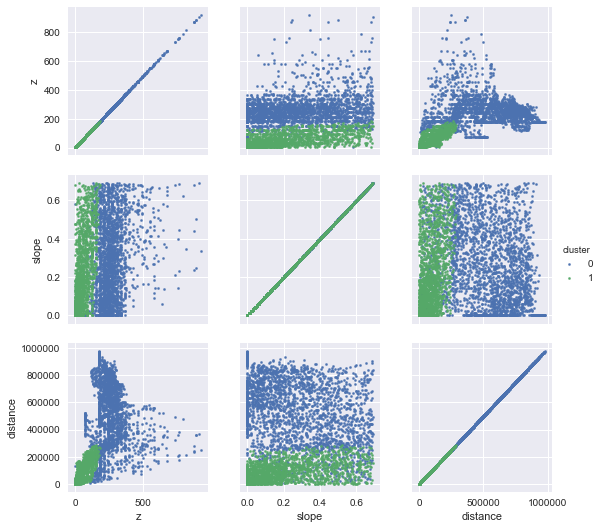

In [88]:
### PLOT SOME MORE RESULTS:
pg = sns.PairGrid(data=df2, vars=['z','slope','distance'],  hue='cluster')
pg.map(plt.scatter,  s=5)
pg.add_legend()

Constraining slopes to <= 0.69 degrees does indeed change the character of the GMM outcome. Let's look more closely at a few of the plots to see how what the GMM can tell us about the data.

[]

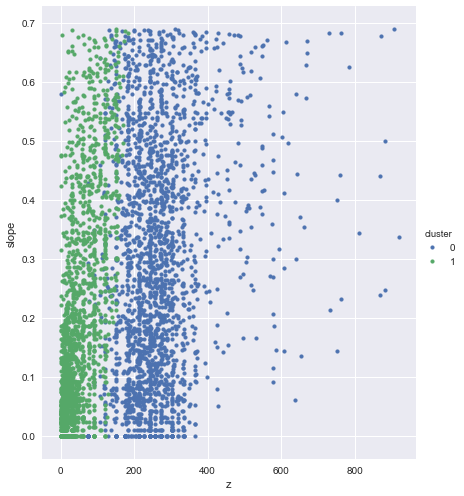

In [101]:
### SCATTER PLOT (CLOSE UP): SLOPE vs ELEVATION
#clrs=['red', 'blue']
fg=sns.FacetGrid(data=df2, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'z', 'slope',  s=14)
fg.add_legend()
plt.plot(x=(170, 170), y=(-0.005,0.71), lw=2)

Limiting slope to less than 0.7 degrees leaves behind a clearer (but not clear) picture of slope's influence on any topographic characteristics that might lend themselves to separating a coastal plain topography from the adjoining upland--it would appear that that influence is minimal. True, we did [sort of] place an artificial constraint on slope which would certainly have an impact on its overall contribution to the variance in the data. And, we have lessened that variance for having limited slope's domain. Still, this constraint is based on some reasonably solid reasoning (that: 1.) the coastal plain is a logical subaerial geomorphic extension of the continental margin (particularly the continental shelf) and 2.) the slope constraint (0 - 0.69 degrees) is based on published ideas rooted in sediment/fluid dynamics across those margins. Thus, we claim some solid footing upon which to stand. 

As for the detail behind the elevation-slope plot seen above, we can present an interpretation that goes something like this:

1.) The two coarsely distributed, higher-density vertical 'bands' of data points seen in the plot, and the lower density gap that can be seen between them, could reflect the lower coastal plains and uplands, respectively, with the gap marking the "fall-line" transition.

2.) the coalesed grouping (higher density) of 'green' sample points sitting in the lower-left corner of the plot may further reflect the broader expanses of coastal plain seen across the southern end of the study area (S. GA and N. FL). We saw this reflected in the earlier EDA y-coordinate/elevation plots (see notebook: Topographic Classification, A Machine Learning Approach-EDA for the details) in the low, flat region along the lower-left.

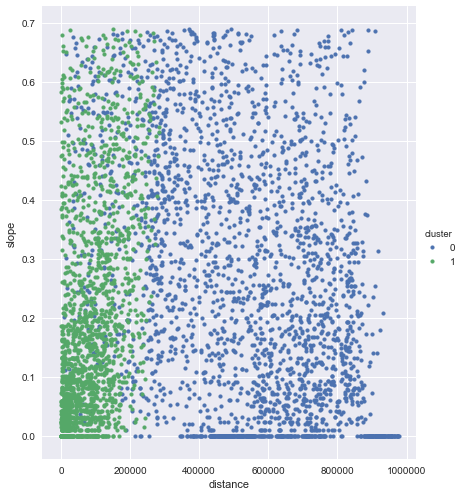

In [99]:
### SCATTER PLOT (CLOSE UP): SLOPE vs DISTANCE FROM SHORE
fg=sns.FacetGrid(data=df2, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'distance', 'slope', s=14)
fg.add_legend()

Similar to what was seen with elevation versus slope, the two most salient structural features in the above plot are the vertical banding (though more subtle here) and the coalesense at the lower-left corner. The point scatter here does suggest what might be obvious (from intuition): that one can expect to find low sloped terrain across the entire study region, with the expectation that there are more of these terrains closer to the coast, and fewer as one approaches first the uplands, than the mountain ranges and plateau to the west. It is the coalesence that we see in the plot's lower-left corner that is most suggestive, and the most tempting to assign significance to. We should thus be careful here in our assumptions. Nevertheless, we have to start somewhere, and this patch of green in the lower-left is as good as any, I suppose. Still, even if it does reflect a coastal plain 'signal' slope doesn't appear to have sufficient influence (anymore) to suggest that it would be amenable to unsupervised classification. We should look further, and hope, for a more definitive relationship between elevation and distance to shoreline.

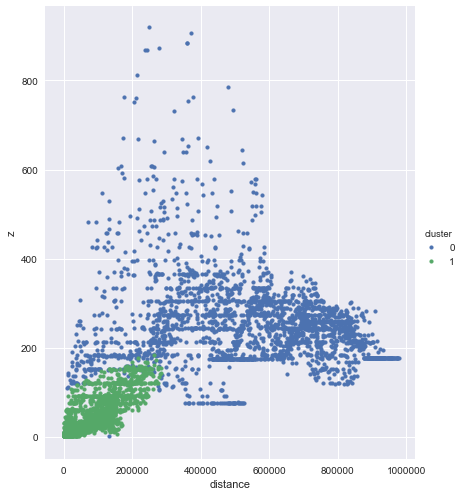

In [93]:
### SCATTER PLOT (CLOSE UP): SLOPE vs DISTANCE FROM SHORE
fg=sns.FacetGrid(data=df2, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'distance', 'z', s=14)
fg.add_legend()

Separation between the two clusters looks encouraging. There appears to be some overlap (which is to be expected--the real world is pretty complex, after all) but not so much that a more sophisticated supervised classifier might be devised to reasonably well discriminate and so model coastal plain topographies. Let's have a closer look at the plot's lower left corner to  get a better feel for the separation and a qualitative goodness of fit assessment for something like a Support Vector Machine.

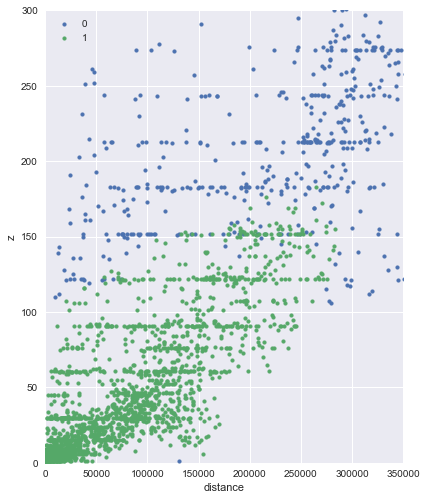

In [96]:
### REPEATING THE PRIOR PLOT, but with a closer look at the lower left corner (where the
### interesting stuff is happening):

fg=sns.FacetGrid(data=df2, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'distance', 'z', s=14)
plt.xlim((0,350000))
plt.ylim((0,300))
plt.legend(loc='best')

Separation between the two regions appears to be pretty good. There is some overlap at the edges, but the density gradiation (from lower-left arcing toward the upper-right) and the resulting partitioning might suggest that a Support Vector Machine learning model, with a radial basis function kernel (or maybe a 2nd or 3rd degree polynomial), might fit the data pretty well. 

!

In [107]:
probs = gmx.predict_proba(X)
print(probs[:100].round(3))

[[ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 0.016  0.984]
 [ 0.002  0.998]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 0.101  0.899]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.   ]
 [ 1.     0.  